In [2]:
# House Price Prediction (Regression) 
#  1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

%matplotlib inline
sns.set(style="whitegrid")


In [3]:
#2: Csv File 
df = pd.read_csv('housing.csv')
df.head()


,location,size_sqft,rooms,age,price
0,Downtown,1500,3,5,250000
1,Suburb,1200,2,10,180000
2,Countryside,2000,4,20,220000
3,Downtown,850,2,2,175000
4,Uptown,1350,3,8,210000


Shape: (10, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   location   10 non-null     object
 1   size_sqft  10 non-null     int64 
 2   rooms      10 non-null     int64 
 3   age        10 non-null     int64 
 4   price      10 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 532.0+ bytes


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
location,10,4,Downtown,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size_sqft,10.0,NaN,NaN,NaN,1525.0,453.535494,850.0,1237.5,1475.0,1750.0,2400.0
rooms,10.0,NaN,NaN,NaN,3.1,0.994429,2.0,2.25,3.0,3.75,5.0
age,10.0,NaN,NaN,NaN,10.7,7.454305,2.0,5.5,9.0,14.25,25.0
price,10.0,NaN,NaN,NaN,212000.0,29646.060259,175000.0,191250.0,205000.0,235000.0,260000.0



Missing values per column:
 location     0
size_sqft    0
rooms        0
age          0
price        0
dtype: int64

Location distribution:
 location
Downtown       3
Suburb         3
Countryside    2
Uptown         2
Name: count, dtype: int64


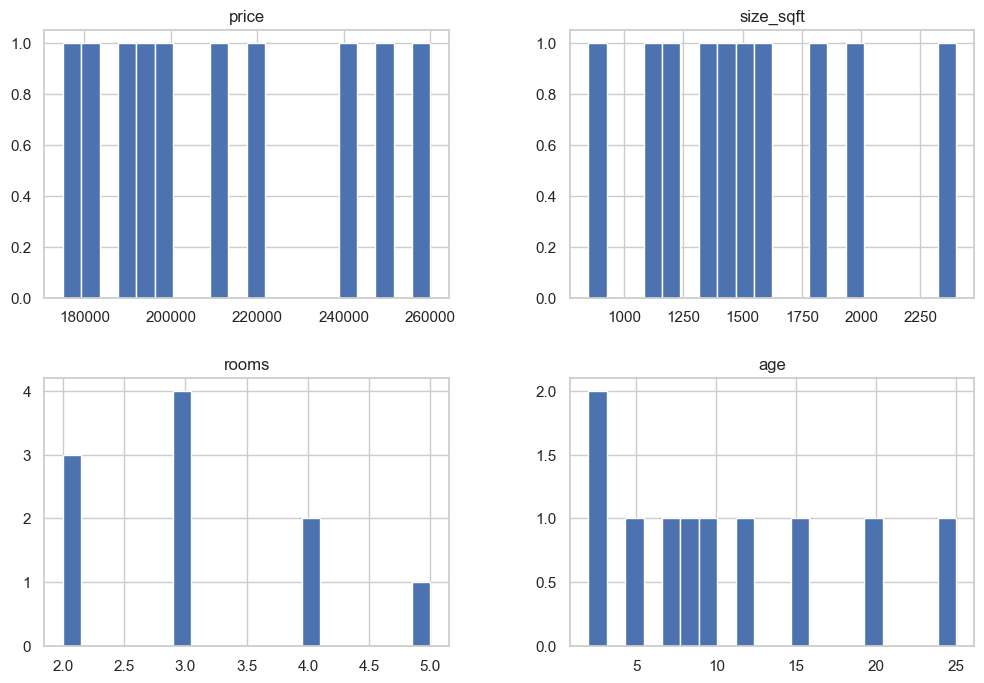

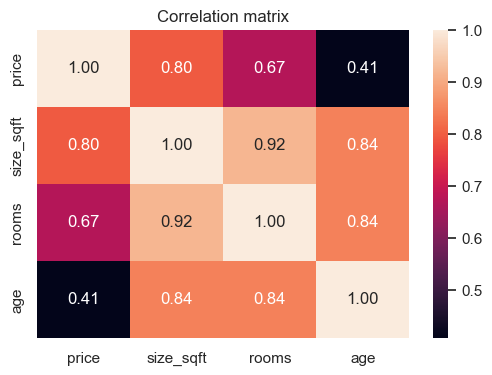

In [4]:
#  3: EDA
print("Shape:", df.shape)
display(df.info())
display(df.describe(include='all').T)

# Missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Value counts for categorical feature(s)
print("\nLocation distribution:\n", df['location'].value_counts())

# Histograms and scatter
df[['price','size_sqft','rooms','age']].hist(bins=20, figsize=(12,8))
plt.show()

# Correlation heatmap for numeric columns
plt.figure(figsize=(6,4))
sns.heatmap(df[['price','size_sqft','rooms','age']].corr(), annot=True, fmt=".2f")
plt.title("Correlation matrix")
plt.show()


In [7]:
# 4: Preproccessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Features
numeric_features = ['size_sqft', 'rooms', 'age']     # change if your dataset has different names
categorical_features = ['location']

# Numeric transformer: fill missing with median + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer: fill missing with most_frequent + one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # FIXED
])

# Combine both into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [8]:
#  5: Train/test split
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (8, 4) Test size: (2, 4)


In [9]:
#  6: Linear Regression pipeline & evaluation function
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

metrics_lr = regression_metrics(y_test, y_pred_lr)
metrics_lr


{'MAE': 20182.692307692298,
 'MSE': 407360507.5813606,
 'RMSE': np.float64(20183.17387284172),
 'R2': 0.5473772137984882}

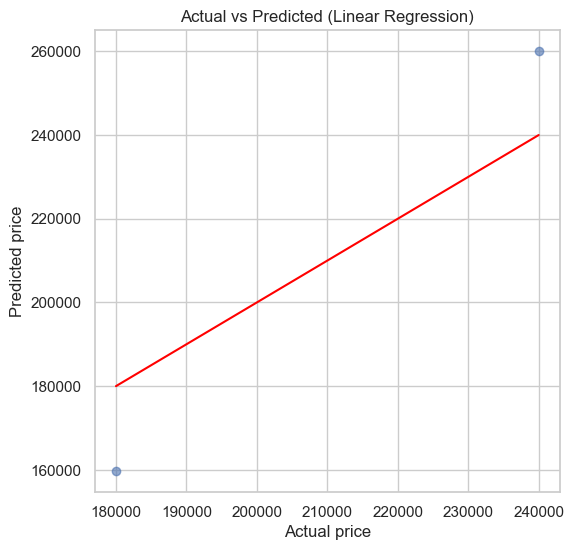

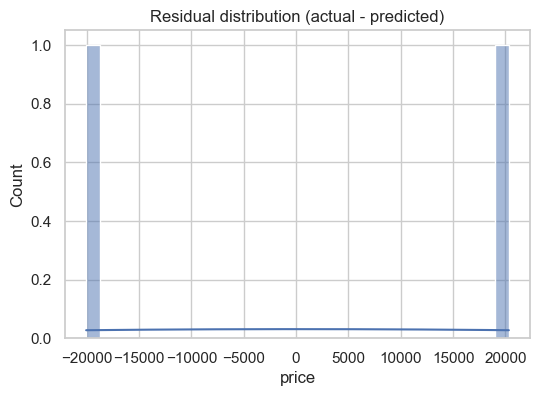

In [10]:
# 7: Diagnostics plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs Predicted (Linear Regression)')
plt.show()

residuals = y_test - y_pred_lr
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual distribution (actual - predicted)")
plt.show()


In [11]:
#  8: RandomForest pipeline with hyperparameter search
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20]
}

grid = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
metrics_rf = regression_metrics(y_test, y_pred_rf)
metrics_rf


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'regressor__max_depth': None, 'regressor__n_estimators': 100}


{'MAE': 15100.0,
 'MSE': 228500000.0,
 'RMSE': np.float64(15116.216457830975),
 'R2': 0.7461111111111112}

size_sqft               0.443077
age                     0.211017
rooms                   0.121295
location_Suburb         0.083600
location_Countryside    0.055078
location_Uptown         0.050603
location_Downtown       0.035331
dtype: float64

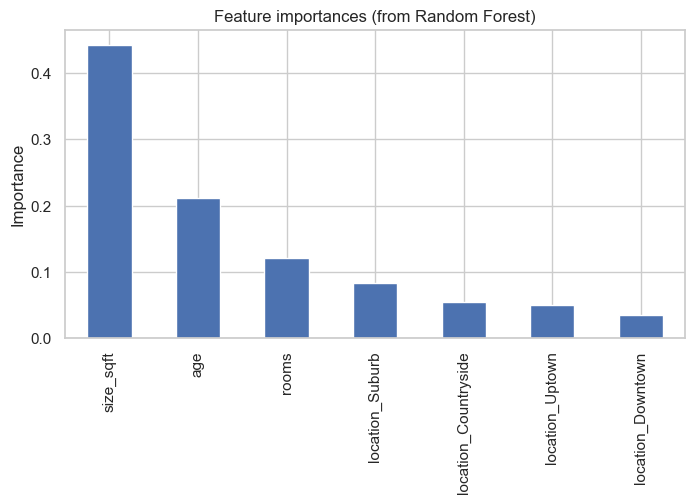

In [12]:
#  9: Feature importances — map back to original feature names
# build feature name list after transformation
ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_feature_names)

importances = best_rf.named_steps['regressor'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
display(feat_imp)

plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title('Feature importances (from Random Forest)')
plt.ylabel('Importance')
plt.show()


In [13]:
#  10: Save trained model
joblib.dump(best_rf, 'house_price_model.joblib')
print("Saved house_price_model.joblib")

# Example: load and predict on a new sample
loaded_model = joblib.load('house_price_model.joblib')
sample = pd.DataFrame([{'location':'Downtown','size_sqft':1500,'rooms':3,'age':5}])
predicted_price = loaded_model.predict(sample)[0]
print("Predicted price for sample:", predicted_price)


Saved house_price_model.joblib
Predicted price for sample: 232450.0
